Use this notebook to run allocation strategies on available equity data.

Download historical stock prices from the following:
- https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018

S&P500 weights obtained from: https://www.slickcharts.com/sp500 (04/07/2021)

In [119]:
# Analysis
import pandas as pd
import numpy  as np
import os

# Data import
import zipfile

# Visualization
import matplotlib.pyplot as plt

# Misc
from datetime import datetime as dtime, timedelta as tdelta

pd.options.mode.chained_assignment = None  # default='warn'

### Unzip

In [3]:
full_path = os.getcwd()

In [ ]:
# Extract stock prices from zip
zip_ref   = zipfile.ZipFile(full_path + "/archive.zip", 'r')
zip_ref.extractall(full_path + "/data")
zip_ref.close()

### Historical Stock Prices

In [18]:
stock_prices_df = pd.read_csv(
    full_path + "/data/historical_stock_prices.csv",
    parse_dates = ["date"],
    usecols     = ["date", "ticker", "adj_close"]
)

In [19]:
# Filter by date

START_DATE_FILTER = dtime(2005,  1,  1)
END_DATE_FILTER   = dtime(2017, 12, 31)

stock_prices_df = stock_prices_df[
    (stock_prices_df.date >= START_DATE_FILTER) &
    (stock_prices_df.date <=   END_DATE_FILTER)
]

In [20]:
# Get list of stocks that have appeared entirely throughout
# the filtered date range
#
# There are 1926 tickers that satisfy this criteria

total_dates       = len(stock_prices_df.date.unique())
stock_appearances = stock_prices_df.ticker.value_counts()
filtered_stock    = pd.DataFrame(
    data = {"ticker": stock_appearances[stock_appearances == total_dates].index}
)

stock_prices_df   = pd.merge(stock_prices_df, filtered_stock, on="ticker", how="inner")

In [21]:
stock_prices_df.head()

,ticker,adj_close,date
0,GTN,11.976990,2005-01-03
1,GTN,11.504106,2005-01-04
2,GTN,11.414422,2005-01-05
3,GTN,11.373655,2005-01-06
4,GTN,11.422575,2005-01-07


### S&P500 Tickers + Weights

Note: Only the current weights are provided

In [22]:
sp_500           = pd.read_csv(full_path + "/data/sp500.csv")
sp_500["weight"] = sp_500["weight"] / sp_500["weight"].sum()

In [23]:
sp_500.head()

,ticker,weight
0,AAPL,0.057776
1,MSFT,0.054229
2,AMZN,0.040028
3,FB,0.021370
4,GOOGL,0.019273


### Cleaning and filtering into S&P500 stocks (~391 resulting tickers)

In [24]:
# Additionally filter by stocks contained within the S&P500
#
# 391 tickers satisfy this criteria

filtered_df = stock_prices_df.merge(sp_500, on="ticker", how="inner")
filtered_df = filtered_df.drop("weight", axis=1)

In [25]:
len(filtered_df.ticker.unique())

391

In [26]:
filtered_df.head()

,ticker,adj_close,date
0,AAPL,3.037917,2005-01-03
1,AAPL,3.069117,2005-01-04
2,AAPL,3.095998,2005-01-05
3,AAPL,3.098397,2005-01-06
4,AAPL,3.323997,2005-01-07


### Calculate log performance

In [30]:
stock_performances = {}

for ticker in filtered_df.ticker.unique():
    temp                   = filtered_df[filtered_df.ticker == ticker]
    temp["ln_adj_close_1"] = np.log(temp.adj_close)
    temp["ln_adj_close_2"] = temp.ln_adj_close_1.shift(-1)
    temp["ln_return"]      = temp.ln_adj_close_2 - temp.ln_adj_close_1
    temp                   = temp.drop(["ln_adj_close_1", "ln_adj_close_2"], axis=1)
    stock_performances[ticker] = temp

In [14]:
stock_performances["AAPL"].head()

,ticker,adj_close,date,ln_return
0,AAPL,3.037917,2005-01-03,0.010218
1,AAPL,3.069117,2005-01-04,0.008720
2,AAPL,3.095998,2005-01-05,0.000775
3,AAPL,3.098397,2005-01-06,0.070283
4,AAPL,3.323997,2005-01-07,-0.004197


In [15]:
final_df = pd.DataFrame()

for k, v in stock_performances.items():
    final_df = final_df.append(v)
    
final_df = final_df.fillna(0)
final_df = final_df.set_index("date")

In [194]:
stock_ln_returns = final_df.pivot_table(index="date", columns="ticker", values="ln_return")

In [196]:
ticker_order = stock_ln_returns.columns.tolist()

In [197]:
# Returns a 1/N allocation
# 
# Because the number of stocks listed in the exchange has changed significantly over time, it's
# important to have this dynamically updated everytime the date is changed and the "available"
# amount of tickers changes
def construct_uniform_weights(tickers, date_time):
    weights = np.repeat(1.0 / len(tickers), len(tickers))
    
    return {"ticker": tickers, "weight": weights}

def construct_sp500_weights(tickers, date_time):
    return {
        "ticker": sp_500.ticker,
        "weight": sp_500.weight
    }

**Maximum diversification weighting**:

Goal: Create portfolios that have minimally correlated assets, lower risk levels, and possibly higher returns.

(Introduced by Choueifaty and Coignard, 2008 and Pemberton & Rau, 2007)

The objective is to find the weight $w$ that maximizes the following:

$
\max_w \frac{w^T a}{\sqrt{w_T \Sigma w }}
$

We obtain the following analytical solution:

$
w_{MD} = \frac{\Sigma^{-1} \sigma}{\sigma^T \Sigma^{-1} \sigma}
$

The covariance matrix is determined at each datetime separately. We specifically use the last 252 days of trading prices to determine the covariance matrix.

### Statistical Calculations

Calculate covariance matrix ($\Sigma$) and inverse covariance matrix ($\Sigma^{-1}$) on stock log returns

Calculate volatility ($\sigma$) on stock log returns

In [198]:
def get_cov_ln_returns(tickers, start_date, end_date):
    tickers = list(set(stock_ln_returns.columns).intersection(tickers))
    
    return stock_ln_returns[tickers][(start_date <= stock_ln_returns.index) & \
                            (stock_ln_returns.index <= end_date)].cov()

def get_std_ln_returns(tickers, start_date, end_date):
    tickers = list(set(stock_ln_returns.columns).intersection(tickers))
    
    return stock_ln_returns[tickers][(start_date <= stock_ln_returns.index) & \
                            (stock_ln_returns.index <= end_date)].std()

In [226]:
def construct_max_diverse_weights(tickers, date_time):
    
    # Calculate covariance on last 365 days (~ 252 trading days)
    stock_ln_returns_cov = get_cov_ln_returns(
        tickers, 
        date_time + tdelta(days = -365), 
        date_time + tdelta(days = -1)
    ).values
    
    stock_ln_returns_cov_inv = np.linalg.inv(stock_ln_returns_cov)
                          
    # Calculate volatility on last 365 days (~ 252 trading days)
    stock_ln_returns_vol = get_std_ln_returns(
        tickers, 
        date_time + tdelta(days = -365), 
        date_time + tdelta(days = -1)
    ).values
    
    max_diverse_weight = (stock_ln_returns_cov_inv @ stock_ln_returns_vol) / \
    (stock_ln_returns_vol.T @ stock_ln_returns_cov_inv @ stock_ln_returns_vol)
    
    max_diverse_weight = np.maximum(max_diverse_weight, 0)
    
    norm_factor = np.sum(max_diverse_weight)
    
    return {
        "ticker": tickers,
        "weight": max_diverse_weight / norm_factor
    }

### Covariance 


### Measuring Performance

In [186]:
# Input arguments
# ===============
# weight_function: *Function* with the following (possibly optional) inputs:
#                     - current stocks / tickers
#                     - datetime
#                  and outputs a *Dictionary* of weights corresponding to the allocation at that time
# start_date:      When to start the allocation strategy
# end_date:        When to end the allocation strategy
#
# Returns an np.array of wealth for the dates falling within the start_date and end_date 
def execute_strategy(df, weight_function, start_date, end_date):
    date_range = pd.date_range(start_date, end_date)
    
    valid_dates, log_perfs = np.array([]), np.array([])
    
    for date_time in date_range:
        
        # May be the case on a weekend, holiday, or other non-trading data
        if date_time not in df.index: 
            continue
            
        valid_dates = np.append(valid_dates, date_time)
            
        # Dynamic calculation of weights
        tickers     = np.array(df.loc[date_time].ticker)
        weights     = weight_function(tickers = tickers, date_time = date_time)
        weight_df   = pd.DataFrame(data = weights).set_index("ticker")
        
        current_day_df = df.loc[date_time]
        current_day_df = pd.merge(current_day_df, weight_df, how='left', on='ticker')

        log_perf    = np.sum(current_day_df.weight * current_day_df.ln_return)
        log_perfs   = np.append(log_perfs, log_perf)
            
    return valid_dates, log_perfs

### Uniform Weighting

In [229]:
uniform_dates, uniform_perfs = execute_strategy(
    final_df,
    weight_function = construct_uniform_weights, 
    start_date      = dtime(2007, 1, 1), 
    end_date        = dtime(2017, 12, 31)
)

### SP&500 Weighting

In [230]:
sp500_dates, sp500_perfs = execute_strategy(
    final_df,
    weight_function = construct_sp500_weights, 
    start_date      = dtime(2007, 1, 1), 
    end_date        = dtime(2017, 12, 31)
)

### Maximum Diversification Weighting

Using past 365 day (252 trading days) data.

In [227]:
max_diverse_dates, max_diverse_perfs = execute_strategy(
    final_df,
    weight_function = construct_max_diverse_weights, 
    start_date      = dtime(2007, 1, 1), 
    end_date        = dtime(2017, 12, 31)
)

### Visualization

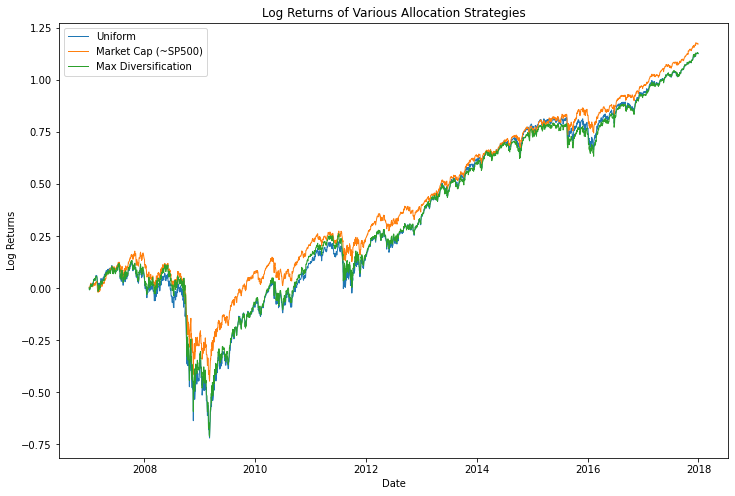

In [231]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(uniform_dates,     np.cumsum(uniform_perfs),     linewidth=1.0, label="Uniform")
ax.plot(sp500_dates,       np.cumsum(sp500_perfs),       linewidth=1.0, label="Market Cap (~SP500)")
ax.plot(max_diverse_dates, np.cumsum(max_diverse_perfs), linewidth=1.0, label="Max Diversification")
ax.set_title("Log Returns of Various Allocation Strategies")
ax.set_xlabel("Date")
ax.set_ylabel("Log Returns")
ax.legend()
plt.show()